In [1]:
PATH_TO_CSV = "/home/mehdi/minecraft-copilot-ml/output/lightning_logs/version_0/metrics.csv"
PATH_TO_BEST_MODEL = "/home/mehdi/minecraft-copilot-ml/output/best_model.pth"
DATASET = "/home/mehdi/minecraft-copilot-ml/datasets/minecraft_schematics"
DATASET_LIMIT = 100

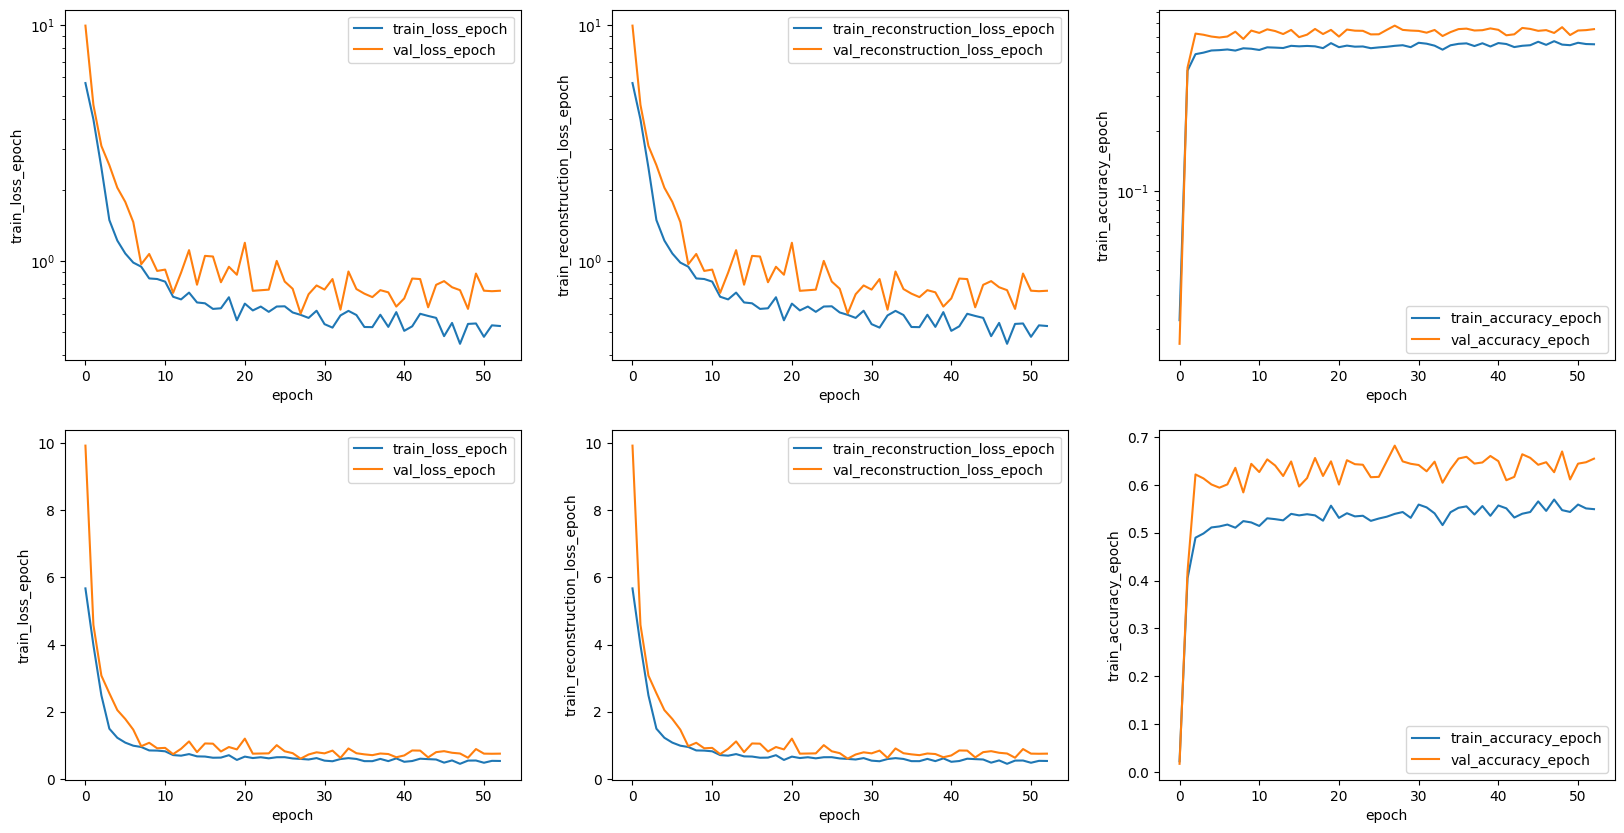

In [2]:
import os
from seaborn import lineplot
import pandas as pd

from matplotlib import pyplot as plt

metrics = ["loss", "reconstruction_loss", "accuracy"]
fig, ax = plt.subplots(2, len(metrics), figsize=(20, 10))

if os.path.exists(PATH_TO_CSV):
    df = pd.read_csv(PATH_TO_CSV)
    for i, metric in enumerate(metrics):
        lineplot(data=df, x="epoch", y=f"train_{metric}_epoch", ax=ax[0, i], label=f"train_{metric}_epoch")
        lineplot(data=df, x="epoch", y=f"val_{metric}_epoch", ax=ax[0, i], label=f"val_{metric}_epoch")
        lineplot(data=df, x="epoch", y=f"train_{metric}_epoch", ax=ax[1, i], label=f"train_{metric}_epoch")
        lineplot(data=df, x="epoch", y=f"val_{metric}_epoch", ax=ax[1, i], label=f"val_{metric}_epoch")
        ax[0, i].set(yscale="log")
        ax[1, i].set(yscale="linear")
else:
    print(f"File {PATH_TO_CSV} not found")

In [3]:
from typing import Any
from matplotlib import pyplot as plt
import numpy as np
from minecraft_copilot_ml.data_loader import (
    get_working_files_and_unique_blocks_and_counts,
    list_schematic_files_in_folder,
)
import matplotlib.cm as cm

colors_palette = cm.get_cmap("tab10").colors

from minecraft_copilot_ml.train import MinecraftSchematicsDataset


def display_voxels(voxel: np.ndarray, zero_block: Any = 0):
    ax = plt.figure().add_subplot(projection="3d")
    unique_values = set(np.unique(voxel))

    colors = np.empty(voxel.shape, dtype=object)
    for i, value in enumerate(unique_values):
        colors[voxel == value] = {colors_palette[i % len(colors_palette)]}
    ax.voxels(voxel != zero_block, facecolors=colors)
    plt.show()


schematics_list_files = list_schematic_files_in_folder(DATASET)
schematics_list_files = sorted(schematics_list_files)
if DATASET_LIMIT is not None:
    schematics_list_files = schematics_list_files[:DATASET_LIMIT]
unique_blocks_dict, unique_counts_coefficients, loaded_schematic_files = get_working_files_and_unique_blocks_and_counts(
    schematics_list_files
)
dataset = MinecraftSchematicsDataset(loaded_schematic_files)

/tmp/ipykernel_9117/3067457714.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_palette = cm.get_cmap("tab10").colors
Found 7345.schematic: : 1it [00:27, 27.03s/it]  
2024-02-18 20:35:12.716 | INFO     | minecraft_copilot_ml.data_loader:list_schematic_files_in_folder:177 - Found 13266 schematics files.
Processing /home/mehdi/minecraft-copilot-ml/datasets/minecraft_schematics/1.schematic:   0%|          | 0/100 [00:00<?, ?it/s]2024-02-18 20:35:13.077 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:air
2024-02-18 20:35:13.078 | INFO     | minecraft_copilot_ml.data_loader:get_working_files_and_unique_blocks_and_counts:197 - Found new block: minecraft:cobblestone
2024-02-18 20:35:13.080 | INFO     | minecraft_copilot_ml.data_loader:

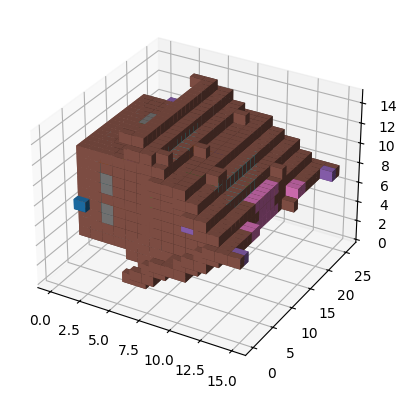

In [4]:
from minecraft_copilot_ml.data_loader import nbt_to_numpy_minecraft_map

minecraft_map = nbt_to_numpy_minecraft_map(schematics_list_files[10])
display_voxels(minecraft_map, zero_block="minecraft:air")

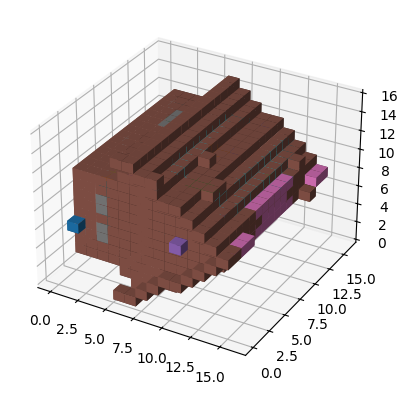

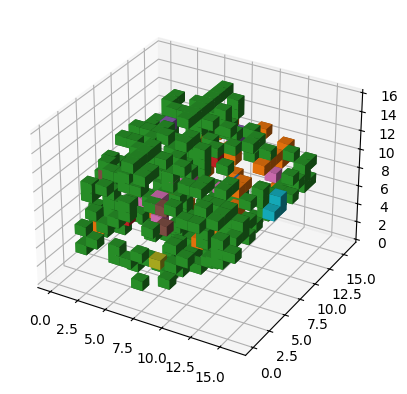

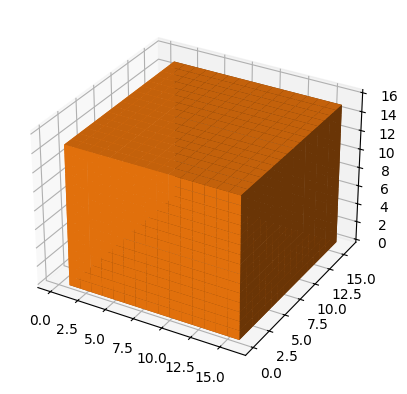

In [5]:
from typing import Any
block_map, noisy_block_map, mask = dataset[10]

display_voxels(block_map, zero_block="minecraft:air")
display_voxels(noisy_block_map, zero_block="minecraft:air")
display_voxels(mask, zero_block=0)

In [6]:
import torch
import torch.nn.functional as F

model = torch.load(PATH_TO_BEST_MODEL)

pre_processed_noisy_block_map = model.pre_process(np.expand_dims(noisy_block_map, axis=0)).unsqueeze(0).float()
reconstruction = model(pre_processed_noisy_block_map)
post_processed_filled_block_map = model.post_process(reconstruction.to("cpu"))
squeezed_post_processed = post_processed_filled_block_map[0]

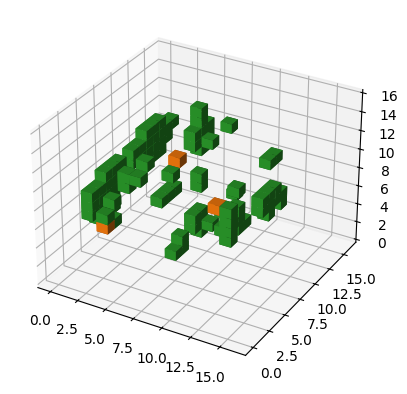

In [7]:
display_voxels(squeezed_post_processed, zero_block="minecraft:air")